In [1]:
import anc2vec

In [2]:
embeds = anc2vec.get_embeddings()

In [3]:
import pandas as pd

In [4]:
df = pd.read_excel("go_terms_channels.xlsx", engine="openpyxl")

In [5]:
go_terms = df["GO Terms"].tolist()

In [6]:
go_embeddings = [embeds[term] for term in go_terms if term in embeds]

In [7]:
feature_vector_an2vec = pd.read_excel("CleanedDataForAnc2vecChannels.xlsx", engine="openpyxl")

In [8]:
feature_vectors = []
for index, row in feature_vector_an2vec.iterrows():
    gene_id = row['GeneID (EntrezGene)']
    uniprot_ac = row['UniProtKB-AC']
    Mito = row["Mito"]
    ER = row["ER"]
    RNA = row["RNA"]
    AGP = row["AGP"]
    DNA = row["DNA"]
    go_term = row['GO Terms']
    
    gene_entry = next((gene for gene in feature_vectors if gene['gene_id'] == gene_id and gene['uniprot_ac'] == uniprot_ac and gene["Mito"] == Mito and gene["ER"] == ER and gene["RNA"] == RNA and gene["AGP"] == AGP and gene["DNA"] == DNA), None)

    if gene_entry is None:
        gene_entry = {'gene_id': gene_id, 'uniprot_ac': uniprot_ac, "Mito" : Mito, "ER" : ER, "RNA" : RNA, "AGP" : AGP, "DNA" : DNA, 'feature_vector': [0] * len(go_terms)}
        feature_vectors.append(gene_entry)

    for i, term in enumerate(go_terms):
        if term == go_term:
            if term in embeds:
                gene_entry['feature_vector'] = [sum(x) for x in zip(gene_entry['feature_vector'], embeds[term])]
            break


In [9]:
data = [[gene_entry['uniprot_ac'], gene_entry['gene_id'], gene_entry['Mito'], gene_entry['ER'], gene_entry['RNA'], gene_entry['AGP'], gene_entry['DNA']] + gene_entry['feature_vector'] for gene_entry in feature_vectors]
CleanedDataForMachineLearning = pd.DataFrame(data, columns=['UniprotAC', 'GeneID', 'Mito', 'ER', 'RNA', 'AGP', 'DNA'] + ["Embed #" + str(i + 1) for i in range(len(go_terms))])
CleanedDataForMachineLearning.dropna(axis=1, how='any', inplace=True)

In [10]:
import matplotlib.pyplot as plt

In [11]:
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, Lasso, Ridge
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import label_binarize, LabelEncoder

In [12]:
X = CleanedDataForMachineLearning.iloc[:, 7:].values.tolist()
print(X[3])
Mito_Y = CleanedDataForMachineLearning['Mito'].tolist()
ER_Y = CleanedDataForMachineLearning['ER'].tolist()
RNA_Y = CleanedDataForMachineLearning['RNA'].tolist()
AGP_Y = CleanedDataForMachineLearning['AGP'].tolist()
DNA_Y = CleanedDataForMachineLearning['DNA'].tolist()


[-0.24970829486846924, -0.579404205083847, 0.2655237317085266, 0.3111008182168007, -0.8412850499153137, -0.8081816285848618, -0.20326949167065322, 1.7271812856197357, 0.7345423512160778, -1.3371860086917877, 0.09025923907756805, 0.3060082197189331, -1.9714155122637749, -0.009652853012084961, -0.15926441550254822, 0.7884303331375122, 0.5329787880182266, -2.8608580008149147, -1.3275598734617233, 1.0294791013002396, 2.2081497460603714, 0.37724171578884125, -0.8363709850236773, -0.2874661460518837, 2.3871824499219656, -1.8212939612567425, 2.7062867302447557, -0.3696771115064621, -0.6683216169476509, -1.3673054203391075, 0.25854648649692535, -3.610320396721363, -2.3001173213124275, 1.166856274008751, 1.2690796703100204, 0.4202597588300705, -1.4660171642899513, 1.2227770760655403, -1.4837201535701752, 0.8207851201295853, 0.12537729367613792, -1.0931113362312317, -2.0423781722784042, 0.5065194368362427, 1.7756934836506844, -2.6785691753029823, -0.1511986255645752, -1.0368824005126953, -0.1568

In [13]:
columns = ['embed_position#' + str(i + 1) for i in range(len(X[0]))]

anc2vec_vectors = pd.DataFrame(X, columns=columns)

anc2vec_vectors.to_excel('Anc2vecChannelsMachineLearning.xlsx', index=False)

In [14]:
label_encoder = LabelEncoder()
y_binary_mito = label_encoder.fit_transform(Mito_Y)
y_binary_er = label_encoder.fit_transform(ER_Y)
y_binary_rna = label_encoder.fit_transform(RNA_Y)
y_binary_agp = label_encoder.fit_transform(AGP_Y)
y_binary_dna = label_encoder.fit_transform(DNA_Y)

In [15]:
cv = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)

In [16]:
random_forest = RandomForestClassifier()

In [17]:
rf_probs_mito = cross_val_predict(random_forest, X, y_binary_mito, cv=cv, method='predict_proba')[:, 1]
rf_fpr_mito, rf_tpr_mito, _ = roc_curve(y_binary_mito, rf_probs_mito)
rf_auc_mito = auc(rf_fpr_mito, rf_tpr_mito)

In [18]:
rf_probs_er = cross_val_predict(random_forest, X, y_binary_er, cv=cv, method='predict_proba')[:, 1]
rf_fpr_er, rf_tpr_er, _ = roc_curve(y_binary_er, rf_probs_er)
rf_auc_er = auc(rf_fpr_er, rf_tpr_er)

In [19]:
rf_probs_rna = cross_val_predict(random_forest, X, y_binary_rna, cv=cv, method='predict_proba')[:, 1]
rf_fpr_rna, rf_tpr_rna, _ = roc_curve(y_binary_rna, rf_probs_rna)
rf_auc_rna = auc(rf_fpr_rna, rf_tpr_rna)

In [20]:
rf_probs_agp = cross_val_predict(random_forest, X, y_binary_agp, cv=cv, method='predict_proba')[:, 1]

rf_fpr_agp, rf_tpr_agp, _ = roc_curve(y_binary_agp, rf_probs_agp)
rf_auc_agp = auc(rf_fpr_agp, rf_tpr_agp)

In [21]:
rf_probs_dna = cross_val_predict(random_forest, X, y_binary_dna, cv=cv, method='predict_proba')[:, 1]

rf_fpr_dna, rf_tpr_dna, _ = roc_curve(y_binary_dna, rf_probs_dna)
rf_auc_dna = auc(rf_fpr_dna, rf_tpr_dna)

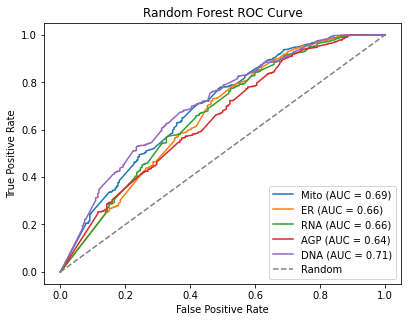

In [22]:
plt.figure(figsize=(6.4, 4.8))
plt.plot(rf_fpr_mito, rf_tpr_mito, label=f'Mito (AUC = {rf_auc_mito:.2f})')
plt.plot(rf_fpr_er, rf_tpr_er, label=f'ER (AUC = {rf_auc_er:.2f})')
plt.plot(rf_fpr_rna, rf_tpr_rna, label=f'RNA (AUC = {rf_auc_rna:.2f})')
plt.plot(rf_fpr_agp, rf_tpr_agp, label=f'AGP (AUC = {rf_auc_agp:.2f})')
plt.plot(rf_fpr_dna, rf_tpr_dna, label=f'DNA (AUC = {rf_auc_dna:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest ROC Curve')
plt.legend()
plt.savefig('Anc2vecRandomForest.png', bbox_inches='tight', facecolor='white', transparent=False, dpi=600)
plt.show()

In [23]:
logistic_regression = LogisticRegression(max_iter = 1000)

In [24]:
lr_probs_mito = cross_val_predict(logistic_regression, X, y_binary_mito, cv=cv, method='predict_proba')[:, 1]

lr_fpr_mito, lr_tpr_mito, _ = roc_curve(y_binary_mito, lr_probs_mito)
lr_auc_mito = auc(lr_fpr_mito, lr_tpr_mito)


In [25]:
lr_probs_er = cross_val_predict(logistic_regression, X, y_binary_er, cv=cv, method='predict_proba')[:, 1]

lr_fpr_er, lr_tpr_er, _ = roc_curve(y_binary_er, lr_probs_er)
lr_auc_er = auc(lr_fpr_er, lr_tpr_er)


In [26]:
lr_probs_rna = cross_val_predict(logistic_regression, X, y_binary_rna, cv=cv, method='predict_proba')[:, 1]

lr_fpr_rna, lr_tpr_rna, _ = roc_curve(y_binary_rna, lr_probs_rna)
lr_auc_rna = auc(lr_fpr_rna, lr_tpr_rna)

In [27]:
lr_probs_agp = cross_val_predict(logistic_regression, X, y_binary_agp, cv=cv, method='predict_proba')[:, 1]

lr_fpr_agp, lr_tpr_agp, _ = roc_curve(y_binary_agp, lr_probs_agp)
lr_auc_agp = auc(lr_fpr_agp, lr_tpr_agp)

In [28]:
lr_probs_dna = cross_val_predict(logistic_regression, X, y_binary_dna, cv=cv, method='predict_proba')[:, 1]

lr_fpr_dna, lr_tpr_dna, _ = roc_curve(y_binary_dna, lr_probs_dna)
lr_auc_dna = auc(lr_fpr_dna, lr_tpr_dna)

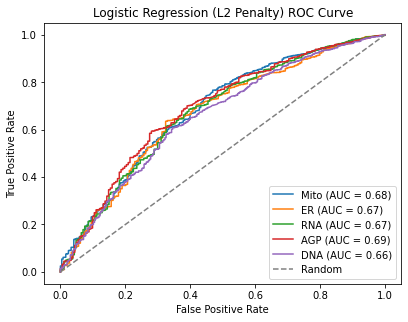

In [29]:
plt.figure(figsize=(6.4, 4.8))
plt.plot(lr_fpr_mito, lr_tpr_mito, label=f'Mito (AUC = {lr_auc_mito:.2f})')
plt.plot(lr_fpr_er, lr_tpr_er, label=f'ER (AUC = {lr_auc_er:.2f})')
plt.plot(lr_fpr_rna, lr_tpr_rna, label=f'RNA (AUC = {lr_auc_rna:.2f})')
plt.plot(lr_fpr_agp, lr_tpr_agp, label=f'AGP (AUC = {lr_auc_agp:.2f})')
plt.plot(lr_fpr_dna, lr_tpr_dna, label=f'DNA (AUC = {lr_auc_dna:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression (L2 Penalty) ROC Curve')
plt.legend()
plt.savefig('Anc2vecLogisticRegression.png', bbox_inches='tight', facecolor='white', transparent=False, dpi=600)
plt.show()

In [30]:
ridge_regression = Ridge()

In [31]:
ridge_probs_mito = cross_val_predict(ridge_regression, X, y_binary_mito, cv=cv)

ridge_fpr_mito, ridge_tpr_mito, _ = roc_curve(y_binary_mito, ridge_probs_mito)
ridge_auc_mito = auc(ridge_fpr_mito, ridge_tpr_mito)

In [32]:
ridge_probs_er = cross_val_predict(ridge_regression, X, y_binary_er, cv=cv)


ridge_fpr_er, ridge_tpr_er, _ = roc_curve(y_binary_er, ridge_probs_er)
ridge_auc_er = auc(ridge_fpr_er, ridge_tpr_er)

In [33]:
ridge_probs_rna = cross_val_predict(ridge_regression, X, y_binary_rna, cv=cv)


ridge_fpr_rna, ridge_tpr_rna, _ = roc_curve(y_binary_rna, ridge_probs_rna)
ridge_auc_rna = auc(ridge_fpr_rna, ridge_tpr_rna)

In [34]:
ridge_probs_agp = cross_val_predict(ridge_regression, X, y_binary_agp, cv=cv)


ridge_fpr_agp, ridge_tpr_agp, _ = roc_curve(y_binary_agp, ridge_probs_agp)
ridge_auc_agp = auc(ridge_fpr_agp, ridge_tpr_agp)

In [35]:
ridge_probs_dna = cross_val_predict(ridge_regression, X, y_binary_dna, cv=cv)


ridge_fpr_dna, ridge_tpr_dna, _ = roc_curve(y_binary_dna, ridge_probs_dna)
ridge_auc_dna = auc(ridge_fpr_dna, ridge_tpr_dna)

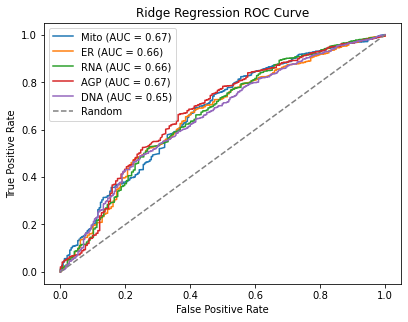

In [36]:
plt.figure(figsize=(6.4, 4.8))
plt.plot(ridge_fpr_mito, ridge_tpr_mito, label=f'Mito (AUC = {ridge_auc_mito:.2f})')
plt.plot(ridge_fpr_er, ridge_tpr_er, label=f'ER (AUC = {ridge_auc_er:.2f})')
plt.plot(ridge_fpr_rna, ridge_tpr_rna, label=f'RNA (AUC = {ridge_auc_rna:.2f})')
plt.plot(ridge_fpr_agp, ridge_tpr_agp, label=f'AGP (AUC = {ridge_auc_agp:.2f})')
plt.plot(ridge_fpr_dna, ridge_tpr_dna, label=f'DNA (AUC = {ridge_auc_dna:.2f})')



plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Ridge Regression ROC Curve')
plt.legend()
plt.savefig('Anc2vecRidgeRegression.png', bbox_inches='tight', facecolor='white', transparent=False, dpi=600)
plt.show()

In [37]:
L1 = LogisticRegression(penalty = 'l1', solver = 'liblinear')

In [38]:
l1_probs_mito = cross_val_predict(L1, X, y_binary_mito, cv=cv, method='predict_proba')[:, 1]

l1_fpr_mito, l1_tpr_mito, _ = roc_curve(y_binary_mito, l1_probs_mito)
l1_auc_mito = auc(l1_fpr_mito, l1_tpr_mito)

In [40]:
l1_probs_er = cross_val_predict(L1, X, y_binary_er, cv=cv, method='predict_proba')[:, 1]

l1_fpr_er, l1_tpr_er, _ = roc_curve(y_binary_er, l1_probs_er)
l1_auc_er = auc(l1_fpr_er, l1_tpr_er)

In [41]:
l1_probs_rna = cross_val_predict(L1, X, y_binary_rna, cv=cv, method='predict_proba')[:, 1]

l1_fpr_rna, l1_tpr_rna, _ = roc_curve(y_binary_rna, l1_probs_rna)
l1_auc_rna = auc(l1_fpr_rna, l1_tpr_rna)

In [42]:
l1_probs_agp = cross_val_predict(L1, X, y_binary_agp, cv=cv, method='predict_proba')[:, 1]

l1_fpr_agp, l1_tpr_agp, _ = roc_curve(y_binary_agp, l1_probs_agp)
l1_auc_agp = auc(l1_fpr_agp, l1_tpr_agp)


In [43]:
l1_probs_dna = cross_val_predict(L1, X, y_binary_dna, cv=cv, method='predict_proba')[:, 1]

l1_fpr_dna, l1_tpr_dna, _ = roc_curve(y_binary_dna, l1_probs_dna)
l1_auc_dna = auc(l1_fpr_dna, l1_tpr_dna)

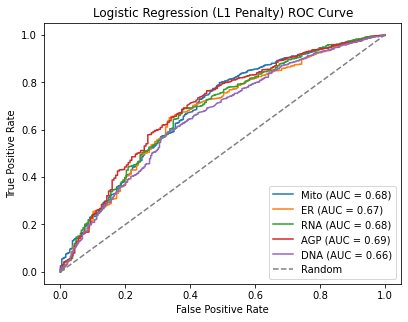

In [44]:
plt.figure(figsize=(6.4, 4.8))
plt.plot(l1_fpr_mito, l1_tpr_mito, label=f'Mito (AUC = {l1_auc_mito:.2f})')
plt.plot(l1_fpr_er, l1_tpr_er, label=f'ER (AUC = {l1_auc_er:.2f})')
plt.plot(l1_fpr_rna, l1_tpr_rna, label=f'RNA (AUC = {l1_auc_rna:.2f})')
plt.plot(l1_fpr_agp, l1_tpr_agp, label=f'AGP (AUC = {l1_auc_agp:.2f})')
plt.plot(l1_fpr_dna, l1_tpr_dna, label=f'DNA (AUC = {l1_auc_dna:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression (L1 Penalty) ROC Curve')
plt.legend()
plt.savefig('Anc2vecL1.png', bbox_inches='tight', facecolor='white', transparent=False, dpi=600)
plt.show()

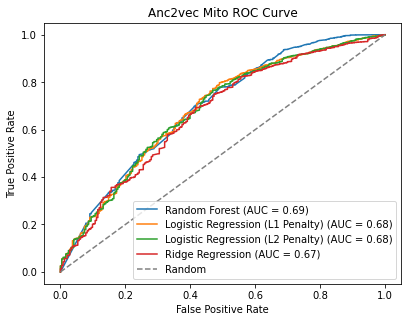

In [45]:
plt.figure(figsize=(6.4, 4.8))
plt.plot(rf_fpr_mito, rf_tpr_mito, label=f'Random Forest (AUC = {rf_auc_mito:.2f})')
plt.plot(l1_fpr_mito, l1_tpr_mito, label=f'Logistic Regression (L1 Penalty) (AUC = {l1_auc_mito:.2f})')
plt.plot(lr_fpr_mito, lr_tpr_mito, label=f'Logistic Regression (L2 Penalty) (AUC = {lr_auc_mito:.2f})')
plt.plot(ridge_fpr_mito, ridge_tpr_mito, label=f'Ridge Regression (AUC = {ridge_auc_mito:.2f})')


plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Anc2vec Mito ROC Curve')
plt.legend()
plt.savefig('Anc2vecMito.png', bbox_inches='tight', facecolor='white', transparent=False, dpi=600)
plt.show()

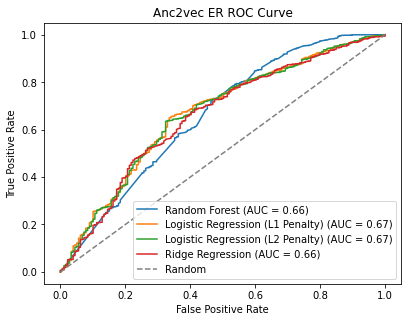

In [46]:
plt.figure(figsize=(6.4, 4.8))
plt.plot(rf_fpr_er, rf_tpr_er, label=f'Random Forest (AUC = {rf_auc_er:.2f})')
plt.plot(l1_fpr_er, l1_tpr_er, label=f'Logistic Regression (L1 Penalty) (AUC = {l1_auc_er:.2f})')
plt.plot(lr_fpr_er, lr_tpr_er, label=f'Logistic Regression (L2 Penalty) (AUC = {lr_auc_er:.2f})')
plt.plot(ridge_fpr_er, ridge_tpr_er, label=f'Ridge Regression (AUC = {ridge_auc_er:.2f})')


plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Anc2vec ER ROC Curve')
plt.legend()
plt.savefig('Anc2vecER.png', bbox_inches='tight', facecolor='white', transparent=False, dpi=600)
plt.show()

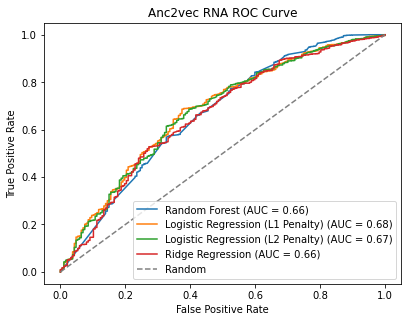

In [47]:
plt.figure(figsize=(6.4, 4.8))
plt.plot(rf_fpr_rna, rf_tpr_rna, label=f'Random Forest (AUC = {rf_auc_rna:.2f})')
plt.plot(l1_fpr_rna, l1_tpr_rna, label=f'Logistic Regression (L1 Penalty) (AUC = {l1_auc_rna:.2f})')
plt.plot(lr_fpr_rna, lr_tpr_rna, label=f'Logistic Regression (L2 Penalty) (AUC = {lr_auc_rna:.2f})')
plt.plot(ridge_fpr_rna, ridge_tpr_rna, label=f'Ridge Regression (AUC = {ridge_auc_rna:.2f})')


plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Anc2vec RNA ROC Curve')
plt.legend()
plt.savefig('Anc2vecRNA.png', bbox_inches='tight', facecolor='white', transparent=False, dpi=600)
plt.show()

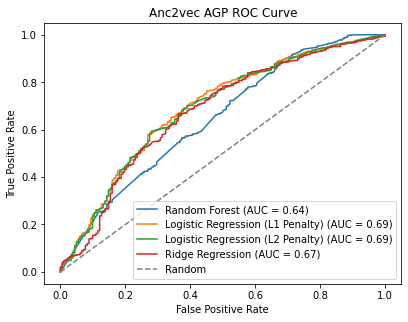

In [48]:
plt.figure(figsize=(6.4, 4.8))
plt.plot(rf_fpr_agp, rf_tpr_agp, label=f'Random Forest (AUC = {rf_auc_agp:.2f})')
plt.plot(l1_fpr_agp, l1_tpr_agp, label=f'Logistic Regression (L1 Penalty) (AUC = {l1_auc_agp:.2f})')
plt.plot(lr_fpr_agp, lr_tpr_agp, label=f'Logistic Regression (L2 Penalty) (AUC = {lr_auc_agp:.2f})')
plt.plot(ridge_fpr_agp, ridge_tpr_agp, label=f'Ridge Regression (AUC = {ridge_auc_agp:.2f})')


plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Anc2vec AGP ROC Curve')
plt.legend()
plt.savefig('Anc2vecAGP.png', bbox_inches='tight', facecolor='white', transparent=False, dpi=600)
plt.show()

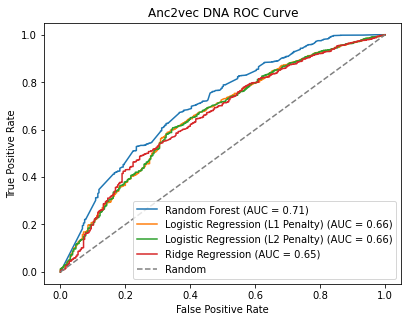

In [49]:
plt.figure(figsize=(6.4, 4.8))
plt.plot(rf_fpr_dna, rf_tpr_dna, label=f'Random Forest (AUC = {rf_auc_dna:.2f})')
plt.plot(l1_fpr_dna, l1_tpr_dna, label=f'Logistic Regression (L1 Penalty) (AUC = {l1_auc_dna:.2f})')
plt.plot(lr_fpr_dna, lr_tpr_dna, label=f'Logistic Regression (L2 Penalty) (AUC = {lr_auc_dna:.2f})')
plt.plot(ridge_fpr_dna, ridge_tpr_dna, label=f'Ridge Regression (AUC = {ridge_auc_dna:.2f})')


plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Anc2vec DNA ROC Curve')
plt.legend()
plt.savefig('Anc2vecDNA.png', bbox_inches='tight', facecolor='white', transparent=False, dpi=600)
plt.show()

In [ ]:
logistic_regression_L1 = LogisticRegression(penalty='l1', solver = 'liblinear', max_iter = 1000)

cv = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)

# Original parameter values
original_C_values = [0.0004, 0.0005, 0.0006]

# Additional values to include
additional_C_values = np.linspace(0.0004, 0.0006, 10)  # 10 evenly spaced values between 0.0004 and 0.0006

# Combining the original and additional values
all_C_values = np.unique(np.concatenate([original_C_values, additional_C_values]))

# Creating the parameter grid
param_grid = {'C': all_C_values}


# Perform GridSearchCV to find the best hyperparameters
grid_search_log = GridSearchCV(logistic_regression_L1, param_grid=param_grid, cv=cv)
grid_search_log.fit(X, y_binary_mito)

# Get the best hyperparameters
best_params_log = grid_search_log.best_params_
print("Best Hyperparameters for Logistic Regression:")
for param, value in best_params_log.items():
    print(f"{param}: {value}")


# Access the grid search results
cv_results = grid_search_log.cv_results_


# Logistic Regression
lr_probs = cross_val_predict(logistic_regression_L1, X, y_binary_mito, cv=cv, method='predict_proba')[:, 1] 


# Logistic Regression
lr_fpr, lr_tpr, _ = roc_curve(y_binary_mito, lr_probs)
lr_auc = auc(lr_fpr, lr_tpr)



# Plotting
plt.plot(lr_fpr, lr_tpr, label=f'Logistic Regression (AUC = {lr_auc:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Mito Hyperparameter ROC Graph')
plt.legend()
plt.show()



# Concatenated Binary+anc2vec

In [14]:
binary_df = pd.read_excel("OntologyChannelsMachineLearning.xlsx", engine="openpyxl" )

In [15]:
anc2vec_df = pd.read_excel("Anc2vecChannelsMachineLearning.xlsx", engine="openpyxl" )

In [16]:
concatenated_df = pd.concat([binary_df, anc2vec_df], ignore_index=False, axis = 1 )

In [17]:
print(concatenated_df)

          Mito        ER       RNA       AGP       DNA  position#1  \
0     Positive  Negative  Negative  Negative  Negative           0   
1     Positive  Negative  Negative  Negative  Negative           0   
2     Positive  Negative  Negative  Negative  Negative           0   
3     Positive  Positive  Positive  Positive  Positive           0   
4     Positive  Positive  Positive  Positive  Positive           0   
...        ...       ...       ...       ...       ...         ...   
8018  Positive  Positive  Positive  Positive  Positive           1   
8019  Positive  Positive  Positive  Positive  Positive           1   
8020  Positive  Positive  Positive  Positive  Positive           0   
8021  Positive  Positive  Positive  Positive  Positive           0   
8022  Positive  Positive  Positive  Positive  Positive           1   

      position#2  position#3  position#4  position#5  ...  embed_position#191  \
0              0           0           0           0  ...            0.000000 

In [32]:
X = concatenated_df.iloc[:, 5:].values.tolist()
Mito_Y = concatenated_df['Mito'].tolist()
ER_Y = concatenated_df['ER'].tolist()
RNA_Y = concatenated_df['RNA'].tolist()
AGP_Y = concatenated_df['AGP'].tolist()
DNA_Y = concatenated_df['DNA'].tolist()

In [33]:
label_encoder = LabelEncoder()
y_binary_mito = label_encoder.fit_transform(Mito_Y)
y_binary_er = label_encoder.fit_transform(ER_Y)
y_binary_rna = label_encoder.fit_transform(RNA_Y)
y_binary_agp = label_encoder.fit_transform(AGP_Y)
y_binary_dna = label_encoder.fit_transform(DNA_Y)

In [34]:
cv = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)

In [35]:
random_forest = RandomForestClassifier()
logistic_regression = LogisticRegression(max_iter = 1000)
ridge_regression = Ridge()

In [36]:
rf_probs_mito = cross_val_predict(random_forest, X, y_binary_mito, cv=cv, method='predict_proba')[:, 1]
rf_fpr_mito, rf_tpr_mito, _ = roc_curve(y_binary_mito, rf_probs_mito)
rf_auc_mito = auc(rf_fpr_mito, rf_tpr_mito)

In [37]:
rf_probs_er = cross_val_predict(random_forest, X, y_binary_er, cv=cv, method='predict_proba')[:, 1]
rf_fpr_er, rf_tpr_er, _ = roc_curve(y_binary_er, rf_probs_er)
rf_auc_er = auc(rf_fpr_er, rf_tpr_er)

In [38]:
rf_probs_rna = cross_val_predict(random_forest, X, y_binary_rna, cv=cv, method='predict_proba')[:, 1]
rf_fpr_rna, rf_tpr_rna, _ = roc_curve(y_binary_rna, rf_probs_rna)
rf_auc_rna = auc(rf_fpr_rna, rf_tpr_rna)

In [39]:
rf_probs_agp = cross_val_predict(random_forest, X, y_binary_agp, cv=cv, method='predict_proba')[:, 1]
rf_fpr_agp, rf_tpr_agp, _ = roc_curve(y_binary_agp, rf_probs_agp)
rf_auc_agp = auc(rf_fpr_agp, rf_tpr_agp)

In [40]:
rf_probs_dna = cross_val_predict(random_forest, X, y_binary_dna, cv=cv, method='predict_proba')[:, 1]
rf_fpr_dna, rf_tpr_dna, _ = roc_curve(y_binary_dna, rf_probs_dna)
rf_auc_dna = auc(rf_fpr_dna, rf_tpr_dna)



In [41]:
lr_probs_mito = cross_val_predict(logistic_regression, X, y_binary_mito, cv=cv, method='predict_proba')[:, 1]
lr_fpr_mito, lr_tpr_mito, _ = roc_curve(y_binary_mito, lr_probs_mito)
lr_auc_mito = auc(lr_fpr_mito, lr_tpr_mito)

In [42]:
lr_probs_er = cross_val_predict(logistic_regression, X, y_binary_er, cv=cv, method='predict_proba')[:, 1]
lr_fpr_er, lr_tpr_er, _ = roc_curve(y_binary_er, lr_probs_er)
lr_auc_er = auc(lr_fpr_er, lr_tpr_er)

In [43]:
lr_probs_rna = cross_val_predict(logistic_regression, X, y_binary_rna, cv=cv, method='predict_proba')[:, 1]
lr_fpr_rna, lr_tpr_rna, _ = roc_curve(y_binary_rna, lr_probs_rna)
lr_auc_rna = auc(lr_fpr_rna, lr_tpr_rna)

In [44]:
lr_probs_agp = cross_val_predict(logistic_regression, X, y_binary_agp, cv=cv, method='predict_proba')[:, 1]
lr_fpr_agp, lr_tpr_agp, _ = roc_curve(y_binary_agp, lr_probs_agp)
lr_auc_agp = auc(lr_fpr_agp, lr_tpr_agp)

In [45]:
lr_probs_dna = cross_val_predict(logistic_regression, X, y_binary_dna, cv=cv, method='predict_proba')[:, 1]
lr_fpr_dna, lr_tpr_dna, _ = roc_curve(y_binary_dna, lr_probs_dna)
lr_auc_dna = auc(lr_fpr_dna, lr_tpr_dna)

In [46]:
ridge_probs_mito = cross_val_predict(ridge_regression, X, y_binary_mito, cv=cv)
ridge_fpr_mito, ridge_tpr_mito, _ = roc_curve(y_binary_mito, ridge_probs_mito)
ridge_auc_mito = auc(ridge_fpr_mito, ridge_tpr_mito)

In [47]:
ridge_probs_er = cross_val_predict(ridge_regression, X, y_binary_er, cv=cv)
ridge_fpr_er, ridge_tpr_er, _ = roc_curve(y_binary_er, ridge_probs_er)
ridge_auc_er = auc(ridge_fpr_er, ridge_tpr_er)

In [48]:
ridge_probs_rna = cross_val_predict(ridge_regression, X, y_binary_rna, cv=cv)
ridge_fpr_rna, ridge_tpr_rna, _ = roc_curve(y_binary_rna, ridge_probs_rna)
ridge_auc_rna = auc(ridge_fpr_rna, ridge_tpr_rna)

In [49]:
ridge_probs_agp = cross_val_predict(ridge_regression, X, y_binary_agp, cv=cv)
ridge_fpr_agp, ridge_tpr_agp, _ = roc_curve(y_binary_agp, ridge_probs_agp)
ridge_auc_agp = auc(ridge_fpr_agp, ridge_tpr_agp)

In [50]:
ridge_probs_dna = cross_val_predict(ridge_regression, X, y_binary_dna, cv=cv)
ridge_fpr_dna, ridge_tpr_dna, _ = roc_curve(y_binary_dna, ridge_probs_dna)
ridge_auc_dna = auc(ridge_fpr_dna, ridge_tpr_dna)

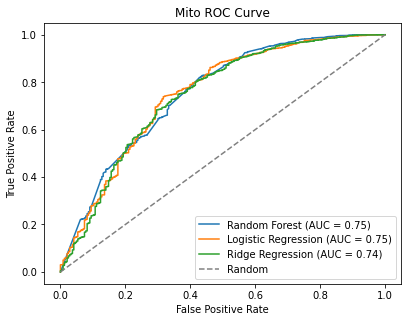

In [51]:
plt.figure(figsize=(6.4, 4.8))
plt.plot(rf_fpr_mito, rf_tpr_mito, label=f'Random Forest (AUC = {rf_auc_mito:.2f})')
plt.plot(lr_fpr_mito, lr_tpr_mito, label=f'Logistic Regression (AUC = {lr_auc_mito:.2f})')
plt.plot(ridge_fpr_mito, ridge_tpr_mito, label=f'Ridge Regression (AUC = {ridge_auc_mito:.2f})')


plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Mito ROC Curve')
plt.legend()
plt.savefig('ConcatenatedMito.png', bbox_inches='tight', facecolor='white', transparent=False, dpi=600)
plt.show()

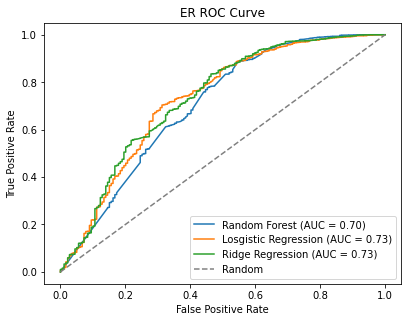

In [52]:
plt.figure(figsize=(6.4, 4.8))
plt.plot(rf_fpr_er, rf_tpr_er, label=f'Random Forest (AUC = {rf_auc_er:.2f})')
plt.plot(lr_fpr_er, lr_tpr_er, label=f'Losgistic Regression (AUC = {lr_auc_er:.2f})')
plt.plot(ridge_fpr_er, ridge_tpr_er, label=f'Ridge Regression (AUC = {ridge_auc_er:.2f})')


plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ER ROC Curve')
plt.legend()
plt.savefig('ConcatenatedER.png', bbox_inches='tight', facecolor='white', transparent=False, dpi=600)
plt.show()

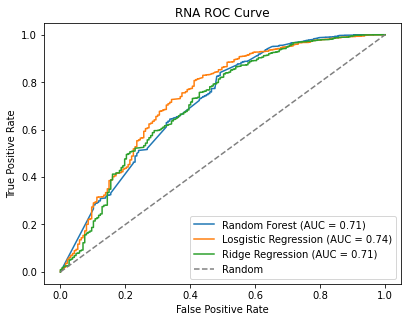

In [54]:
plt.figure(figsize=(6.4, 4.8))
plt.plot(rf_fpr_rna, rf_tpr_rna, label=f'Random Forest (AUC = {rf_auc_rna:.2f})')
plt.plot(lr_fpr_rna, lr_tpr_rna, label=f'Losgistic Regression (AUC = {lr_auc_rna:.2f})')
plt.plot(ridge_fpr_rna, ridge_tpr_rna, label=f'Ridge Regression (AUC = {ridge_auc_rna:.2f})')


plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('RNA ROC Curve')
plt.legend()
plt.savefig('ConcatenatedRNA.png', bbox_inches='tight', facecolor='white', transparent=False, dpi=600)
plt.show()

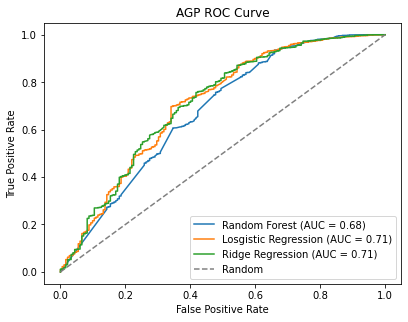

In [55]:
plt.figure(figsize=(6.4, 4.8))
plt.plot(rf_fpr_agp, rf_tpr_agp, label=f'Random Forest (AUC = {rf_auc_agp:.2f})')
plt.plot(lr_fpr_agp, lr_tpr_agp, label=f'Losgistic Regression (AUC = {lr_auc_agp:.2f})')
plt.plot(ridge_fpr_agp, ridge_tpr_agp, label=f'Ridge Regression (AUC = {ridge_auc_agp:.2f})')


plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AGP ROC Curve')
plt.legend()
plt.savefig('ConcatenatedAGP.png', bbox_inches='tight', facecolor='white', transparent=False, dpi=600)
plt.show()

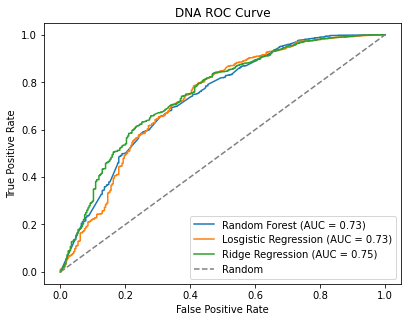

In [56]:
plt.figure(figsize=(6.4, 4.8))
plt.plot(rf_fpr_dna, rf_tpr_dna, label=f'Random Forest (AUC = {rf_auc_dna:.2f})')
plt.plot(lr_fpr_dna, lr_tpr_dna, label=f'Losgistic Regression (AUC = {lr_auc_dna:.2f})')
plt.plot(ridge_fpr_dna, ridge_tpr_dna, label=f'Ridge Regression (AUC = {ridge_auc_dna:.2f})')


plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('DNA ROC Curve')
plt.legend()
plt.savefig('ConcatenatedDNA.png', bbox_inches='tight', facecolor='white', transparent=False, dpi=600)
plt.show()